In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

from background_models import bg_dampe, dphi_de_egb_fermi
from constants import dampe_excess_bin_high, dampe_bins, fermi_psf
from constants import rho_earth, Hz_to_GeV2_cm3
from finite_clump_vectorized import rho_s_dampe, luminosity, dphi_de_g
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint
from finite_clump_vectorized import fermi_point_src_contraint

from nfw_clump import NFW_params
from tt_clump import TT_params

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
# Photon energy at which to compute fluxes
e_gamma_ref = 230.
# Significance used for line width constraint
n_sigma = 3.
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

def mantissa_exp(x):
    exp = np.floor(np.log10(x))
    return x/10**exp, exp

def sci_fmt(val, fmt=".0f"):
    m, e = mantissa_exp(val)
    if e == 0:
        return (r"${:" + fmt + r"}$").format(m)
    else:
        e_str = "{:.0f}".format(e)
        if m == 1:
            return r"$10^{" + e_str + "}$"
        else:
            m_str = ("{:" + fmt + "}").format(m)
            return (r"${" + m_str + r"} \times 10^{" + e_str + "}$")

def log_levels(data, n=10):
    data = [d for d in data.flatten() if d != 0 and not np.isnan(d)]
    return np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), n)

def normal_contours(dist, r_s, val, ax, levels=None, fmt=".0f"):
    """Creates density contour plot with labels.
    """
    if levels is None:
        levels = log_levels(val)
        
    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {level: (r"$" + ("{:" + fmt + "}").format(level) + r"$") for level in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)

def sci_contours(dist, r_s, val, ax, levels=None, fmt=".0f"):
    """Creates density contour plot with labels using scientific notation.
    """
    if levels is None:
        levels = log_levels(val)

    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {level: sci_fmt(level, fmt) for level in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)

def log_contours(dist, r_s, val, ax, levels=None):
    """Creates density contour plot with contour labels at powers of 10.
    """
    if levels is None:
        levels = log_levels(val)

    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {l: (r"$10^{%i}$" % np.log10(l)) for l in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)
    
    
    cs = plt.contour(dist_pr, r_s_pr, val, levels=levels, norm=LogNorm())
    clabels = {pr: (r"$10^{%i}$" % np.log10(pr)) for pr in cs.levels}
    plt.clabel(cs, inline=True, fmt=clabels)

# NFW profile

In [136]:
gamma_nfw = 0.5
# gamma_nfw = 1.

dist = np.logspace(-3, np.log10(3), 5)
r_s = np.logspace(-2, 2, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_nfw = 'data/nfw_gamma_%.1f/' % gamma_nfw

## Load results

In [137]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_nfw = np.loadtxt(
    pr_base_path + "nfw/nfw_gamma_%.2f.csv" % gamma_nfw,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_nfw = pr_nfw.reshape(dist_pr.shape)

## Recompute

### $\rho_s$

In [110]:
rho_s_nfw = rho_s_dampe(dist_mg, r_s_mg, gamma_nfw, "nfw")

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/int

Fill `nan`s by linearly interpolating along the $r_s$ axis

In [113]:
from scipy.interpolate import interp1d

for i in range(3):
    obs_idx = np.where(~np.isnan(rho_s_nfw[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_nfw[obs_idx, i]), fill_value="extrapolate")
    
    nan_idx = np.where(np.isnan(rho_s_nfw[:, i]))[0]
    rho_s_nfw[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [114]:
rho_rel_nfw = (rho_s_nfw + rho_earth) / rho_earth

### $\mathcal{L}$

In [115]:
lum_nfw = luminosity(r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [146]:
dphi_de_g_nfw = dphi_de_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_nfw,
                          gamma_nfw, "nfw", fermi_psf)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [236]:
extent_nfw = gamma_ray_extent(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw",
                              e_gamma_ref, thresh=0.68)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the

### Line width constraint

In [117]:
lw_nfw = line_width_constraint(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", n_sigma)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


### Fermi point source non-detection constraint

In [118]:
rho_s_fermi_ps_nfw = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "nfw")

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [7]:
th_ref = 1. * np.pi / 180  # 1 degree
dphi_de_g_ext_nfw = dphi_de_g(0.99*dampe_excess_bin_high, dist_mg, r_s_mg,
                              rho_s_nfw, gamma_nfw, "nfw", th_ref)
dphi_de_g_ext_rel_nfw = dphi_de_g_ext_nfw / dphi_de_egb_fermi(dampe_excess_bin_high)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


## Save results

In [10]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

## Plot everything together

In [138]:
levels_nfw = {"lum": [4e48, 1e49, 3e49, 1e50, 3e50, 1e51, 3e51, 3e52, 4e54],
              "rho_s": [1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4],
              "dphi_de_g": [5e-17, 1e-16, 3e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13, 1e-12, 1e-10, 1e-8],
              "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
              "extent": [2, 5, 10, 20, 50, 100, 200, 300, 400, 450, 500, 550]}

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


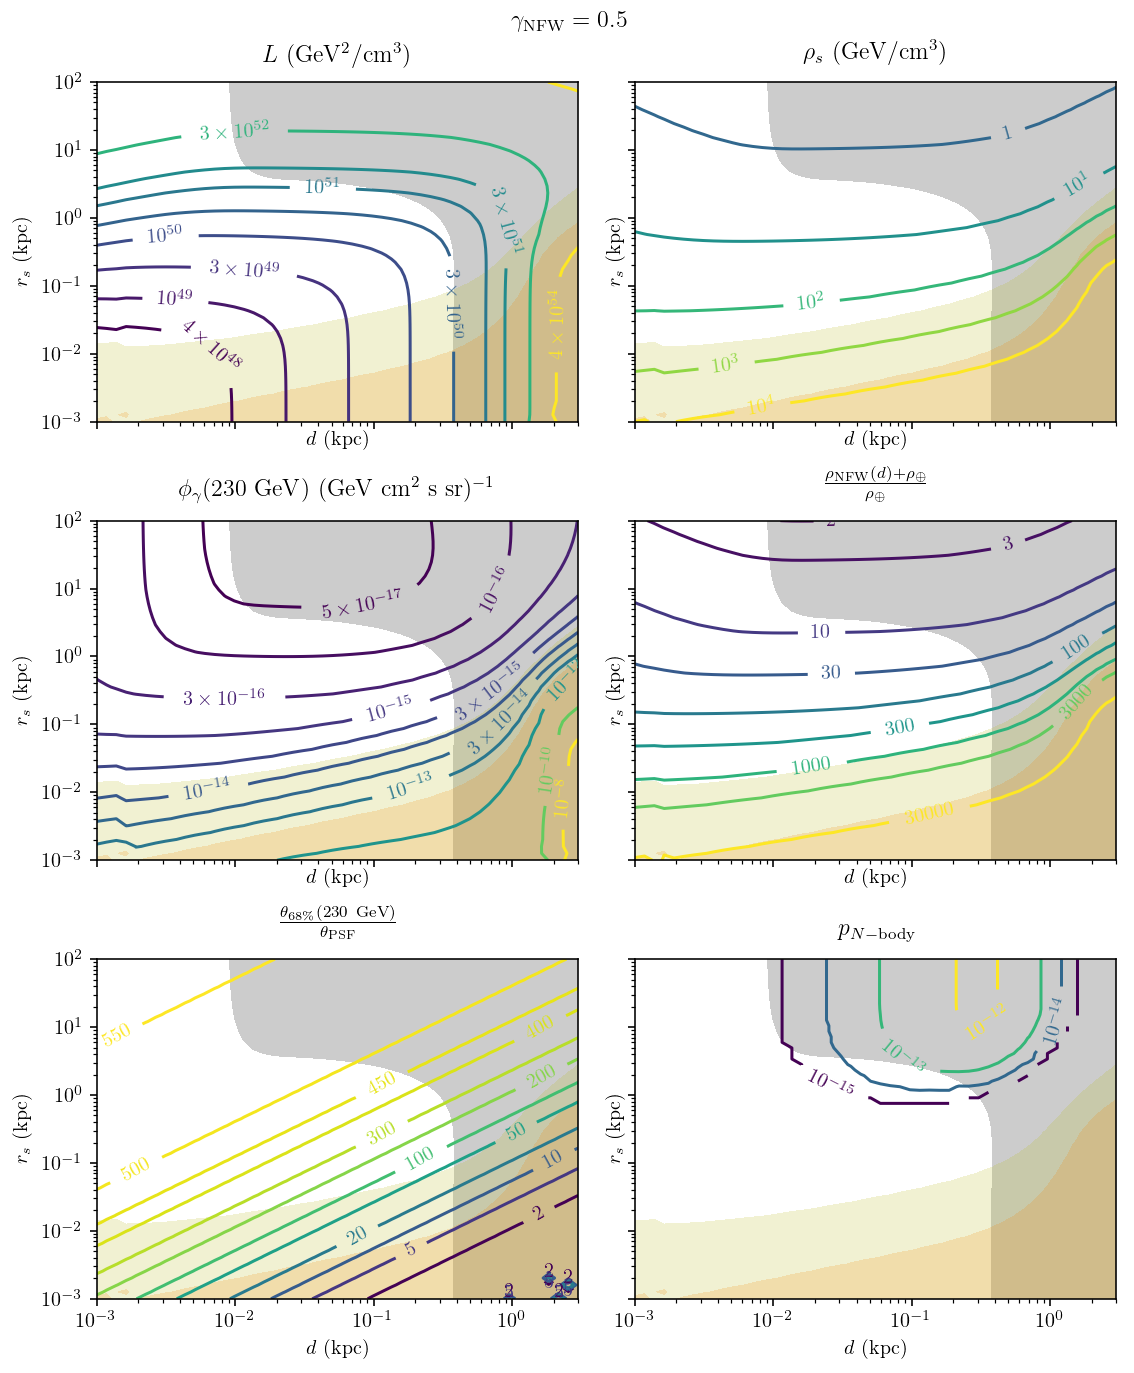

In [139]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

if gamma_nfw == 1:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.0f}".format(gamma_nfw) + r"$")
elif gamma_nfw == 0.5:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.1f}".format(gamma_nfw) + r"$")

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.contourf(dist, r_s, lw_nfw, levels=[n_sigma, np.max(lw_nfw)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist, r_s, rho_s_fermi_ps_nfw - rho_s_nfw, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist, r_s, dphi_de_g_ext_rel_nfw, levels=[1., 1e100],
                colors=[colors[8]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (GeV$^2$/cm$^3$)", pad=10)
sci_contours(dist, r_s, lum_nfw*Hz_to_GeV2_cm3, ax, levels=levels_nfw["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV/cm$^3$)", pad=10)
sci_contours(dist, r_s, rho_s_nfw, ax, levels=levels_nfw["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist, r_s, dphi_de_g_nfw, ax, levels=levels_nfw["dphi_de_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{NFW}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist, r_s, rho_rel_nfw, ax, levels=levels_nfw["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist, r_s, extent_nfw/fermi_psf, ax, levels=levels_nfw["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N {\rm -body}}$", pad=10)
if gamma_nfw == 0.5:
    sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-15, -12, 4))
elif gamma_nfw == 1:
    sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-13, -7, 7))


fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_nfw_gamma_{:.1f}.pdf".format(gamma_nfw))

In [11]:
os.system("say 'Done'")

0

# Exponential/tidally truncated profile

In [10]:
# gamma_exp = 0.52  # 25th percentile
# gamma_exp = 0.74  # median
gamma_exp = 1.08  # 75th percentile

dist = np.logspace(-3, np.log10(3), 50)
r_s = np.logspace(-2, 2, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_exp = 'data/exp_gamma_%.2f/' % gamma_exp

## Load results

In [3]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
    exec(var + "_exp = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")


# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_exp = np.loadtxt(
    pr_base_path + "exp/exp_gamma_%.2f.csv" % gamma_exp,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_exp = pr_exp.reshape(dist_pr.shape)

## Recompute

### $\rho_s$

In [ ]:
rho_s_exp = rho_s_dampe(dist_mg, r_s_mg, gamma_exp, "exp")

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [ ]:
rho_rel_exp = (rho_s_exp + rho_earth) / rho_earth

### $\mathcal{L}$

In [ ]:
lum_exp = luminosity(r_s_mg, rho_s_exp, gamma_exp, "exp")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [ ]:
dphi_de_g_exp = dphi_de_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_exp,
                          gamma_exp, "exp", fermi_psf)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [ ]:
extent_exp = gamma_ray_extent(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp",
                              e_gamma_ref, thresh=0.68)

### Line width constraint

In [ ]:
lw_exp = line_width_constraint(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", n_sigma)

### Fermi point source non-detection constraint

In [ ]:
rho_s_fermi_ps_exp = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_exp, "exp")

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [ ]:
th_ref = 1. * np.pi / 180  # 1 degree
dphi_de_g_ext_exp = dphi_de_g(0.99*dampe_excess_bin_high, dist_mg, r_s_mg,
                              rho_s_exp, gamma_exp, "exp", th_ref)
dphi_de_g_ext_rel_exp = dphi_de_g_ext_exp / dphi_de_egb_fermi(dampe_excess_bin_high)

In [ ]:
plt.contourf(dphi_de_g_ext_rel_exp, levels=[1., 1e100])

## Save results

In [ ]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var + "_exp"), delimiter=',')

In [ ]:
os.system('say "Done computing. Saved the data."')

## Plot everything together

In [ ]:
levels_exp = {}
levels_exp[0.52] = {"lum": [4e48, 1e49, 3e49, 1e50, 3e50, 1e51, 3e51, 3e52, 4e54],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "dphi_de_g": [5e-17, 1e-16, 3e-16, 1e-15, 1e-14, 1e-12, 1e-10, 1e-8],
                    "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[0.74] = {"lum": [4e48, 1e49, 3e49, 1e50, 3e50, 1e51, 3e51, 3e52, 4e54],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "dphi_de_g": [1e-16, 5e-16, 1e-15, 3e-15, 1e-14, 1e-13, 1e-12, 1e-10, 1e-8],
                    "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

fig.suptitle(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma_exp)

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$R_b$ (kpc)")
    # Line width constraint
    ax.contourf(dist, r_s, lw_exp, levels=[n_sigma, np.max(lw_exp)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist, r_s, rho_s_fermi_ps_exp - rho_s_exp, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist, r_s, dphi_de_g_ext_rel_exp, levels=[1., 1e100],
                colors=[colors[8]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (GeV$^2$/cm$^3$)", pad=10)
sci_contours(dist, r_s, lum_exp*Hz_to_GeV2_cm3, ax, levels=levels_exp[gamma_exp]["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_0$ (GeV/cm$^3$)", pad=10)
normal_contours(dist, r_s, rho_s_exp, ax, levels=levels_exp[gamma_exp]["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist, r_s, dphi_de_g_exp, ax, levels=levels_exp[gamma_exp]["dphi_de_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{exp}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist, r_s, rho_rel_exp, ax, levels=levels_exp[gamma_exp]["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist, r_s, extent_exp/fermi_psf, ax, levels=levels_exp[gamma_exp]["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N{\rm -body}}$", pad=10)
log_contours(dist_pr, r_s_pr, pr_exp, ax, levels=np.logspace(-9, -5, num=5))

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_exp_gamma_%.2f.pdf" % gamma_exp)

In [ ]:
os.system('say "Done"')

# Scratch

## Trying to improve numerical stability for extent calculation

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


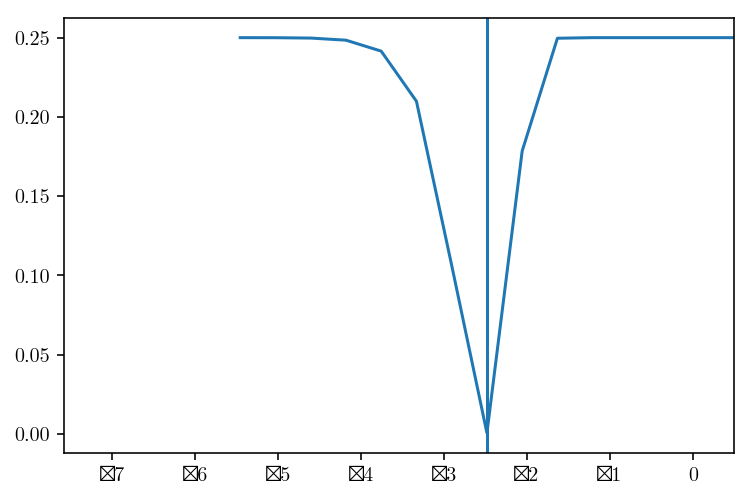

In [7]:
def test_extent():
    dist, r_s, rho_s = 1.9684068735466762, 0.01, 61616.12212771179
    rho_s = 100.
    gamma = gamma_exp
    halo = "exp"
    mx = dampe_excess_bin_high
    sv = 3e-26
    fx = 2.
    e = e_gamma_ref
    thresh = 0.5

    total_flux = dphi_de_g(e, dist, r_s, rho_s, gamma, halo, np.pi,
                           mx, sv, fx)

    def loss(log10_th):
        return (dphi_de_g(e, dist, r_s, rho_s, gamma_exp,
                          "exp", 10.**log10_th,
                          mx, sv, fx) / total_flux - thresh)**2

    bracket_low = np.log10(1e-5 * fermi_psf)
    bracket_high = np.log10(0.99 * np.pi)

    log10_ths = np.linspace(bracket_low, bracket_high, 20)
    losses = np.vectorize(loss)(log10_ths)
    bracket_middle = log10_ths[np.nanargmin(losses)]

    plt.xlim(log10_ths[[0, -1]])
    plt.plot(log10_ths, losses)
    plt.axvline(bracket_middle)
    
    print(np.where(~np.isnan(losses))[0])
    
test_extent()